In [1]:
import numpy as np
import matplotlib.pyplot as plt

from DOE import *
from active_learning import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [2]:
X, Y = ReadExercise1("ex1_data.csv")
cv_metrics = ['neg_mean_squared_error']
save = True

Design of Experiments

In [3]:
error_log = []
cv_error = []
for i in range(30):
    seed = 2024*i
    doe_score, doe_idxs = DOE(X,Y, k=30, seed=seed, cap=20, metric=D_optimal)
    assert len(np.unique(doe_idxs)) == 30
    mask = np.ones(X.shape[0])
    mask[doe_idxs] = False
    mask = np.array(mask, dtype=bool)

    train_x, train_y = X[doe_idxs], Y[doe_idxs]
    test_x, test_y = X[mask], Y[mask]
    
    clf = LinearRegression()
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)

    np.random.seed(seed)
    cv_results = cross_validate(clf, train_x, train_y, scoring=cv_metrics)
    cv_error.append(np.mean(cv_results['test_neg_mean_squared_error']))
    error_log.append(mean_squared_error(test_y,y_pred))

if save:
    np.save("results/DOE_CV_MSE.npy", cv_error)
    np.save("results/DOE_MSE.npy", error_log)

Active Learning with Uncertainty Sampling

In [4]:
error = []
cv_error = []
for i in range(30):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf = clf,cv_metrics=cv_metrics,init_frac=0.1,end_frac=0.3,logging_func=CrossValAndTestLog)
    cv_error.append([ele[0] for ele in res])
    error.append([ele[1] for ele in res])
mse_log = []
cv_error_log = []
for i in range(len(error)):
    mse_log.append(error[i][-1])
    cv_error_log.append(cv_error[i][-1])
mse_log, cv_error_log = np.array(mse_log), np.array(cv_error_log)

if save:
    np.save("results/US_MSE.npy", mse_log)
    np.save("results/US_CV_MSE.npy", cv_error_log)

Passive Learning

In [5]:
error = []
cv_error = []
for i in range(30):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='rand',seed=i*2024,clf = clf,cv_metrics=cv_metrics,init_frac=0.1,end_frac=0.3,logging_func=CrossValAndTestLog)
    cv_error.append([ele[0] for ele in res])
    error.append([ele[1] for ele in res])
mse_log = []
cv_error_log = []
for i in range(len(error)):
    mse_log.append(error[i][-1])
    cv_error_log.append(cv_error[i][-1])
mse_log, cv_error_log = np.array(mse_log), np.array(cv_error_log)

if save:
    np.save("results/PL_MSE.npy", mse_log)
    np.save("results/PL_CV_MSE.npy", cv_error_log)


In [6]:
def PlotData(filepaths,xtick_names):
    weights = []
    errors = []
    for path in filepaths:
        data = np.load(f'results/{path}')
        if np.median(data) < 0:
            data = -data
        weights.append(np.mean(data))
        errors.append(np.std(data))

    fig, ax = plt.subplots(1)
    ax.bar(range(3), weights)    
    ax.errorbar(range(3), weights, errors, color = 'r', linestyle = '', capsize=5)
    ax.set_xticks(range(3), xtick_names)
    return fig, ax

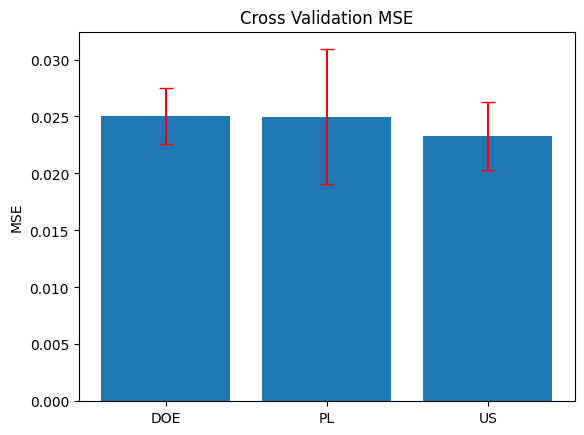

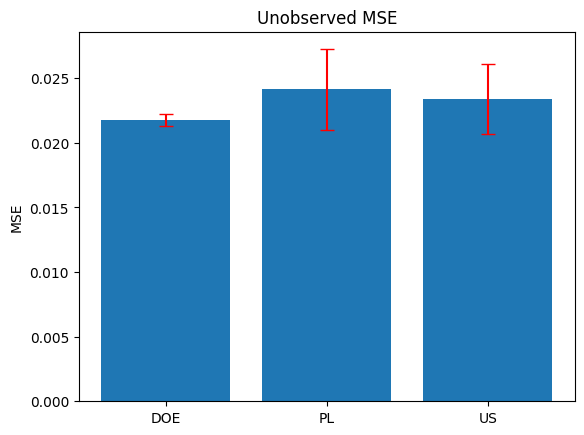

In [7]:
log_types = ['CV_MSE', 'MSE']
for log_type in log_types:
    filenames = [f'DOE_{log_type}.npy',f'PL_{log_type}.npy', f'US_{log_type}.npy']
    xtick_names = ['DOE', 'PL', 'US']
    fig, ax = PlotData(filenames, xtick_names)
    plot_title = ''
    if log_type[:2] == 'CV':
        plot_title = 'Cross Validation '
        log_type = log_type[3:]
    else:
        plot_title = 'Unobserved '
    plot_title = plot_title + log_type
    ax.set_title(plot_title)
    ax.set_ylabel(log_type)
    plt.show(fig)

# PART 2 Of Question 1

DOE combined with Active Learning

In [8]:
cv_metrics = ['neg_mean_squared_error']

In [9]:
error = []
cv_error = []
for i in range(10):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf=clf,cv_metrics=cv_metrics,init_method='DOE',init_frac=0.1,end_frac=0.5,logging_func=CrossValAndTestLog)
    cv_error.append([ele[0] for ele in res])
    error.append([ele[1] for ele in res])

error, cv_error = np.array(error), np.array(cv_error)

if save:
    np.save('results/DOE_US_MSE.npy', error)
    np.save('results/DOE_US_CV_MSE.npy', cv_error)

In [10]:
error = []
cv_error = []
for i in range(10):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf=clf,cv_metrics=cv_metrics,init_method=None,init_frac=0.1,end_frac=0.5,logging_func=CrossValAndTestLog)
    cv_error.append([ele[0] for ele in res])
    error.append([ele[1] for ele in res])
error, cv_error = np.array(error), np.array(cv_error)

if save:
    np.save('results/RAND_US_MSE.npy', error)
    np.save('results/RAND_US_CV_MSE.npy', cv_error)

In [11]:
def PlotData(filepaths, labels):
    fig, ax = plt.subplots(1)
    mse = []
    errors = []
    for path in filepaths:
        data = np.load(f"results/{path}")
        if np.median(data) < 0:
            data = -data
        mse.append(np.mean(data, axis=0))
        errors.append(np.std(data, axis=0))
    
    for data, err, label in zip(mse, errors, labels):
        handle, = ax.plot(range(10, data.shape[0]+10), data, label = label)
        color = handle.get_color()
        ax.errorbar(range(10, data.shape[0]+10), data, err, color = color, linestyle = '', capsize=5, alpha = 0.2)
        ax.legend()

    return fig, ax
    

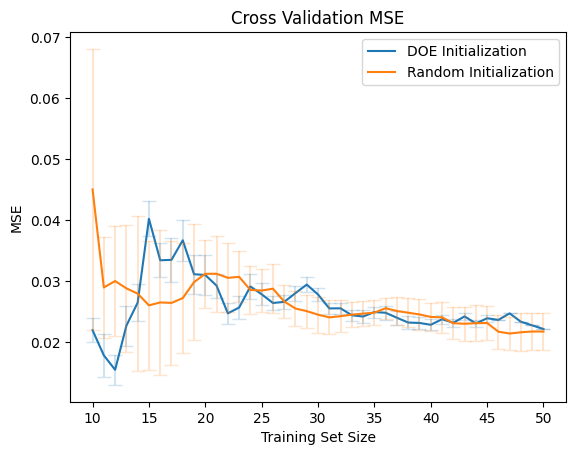

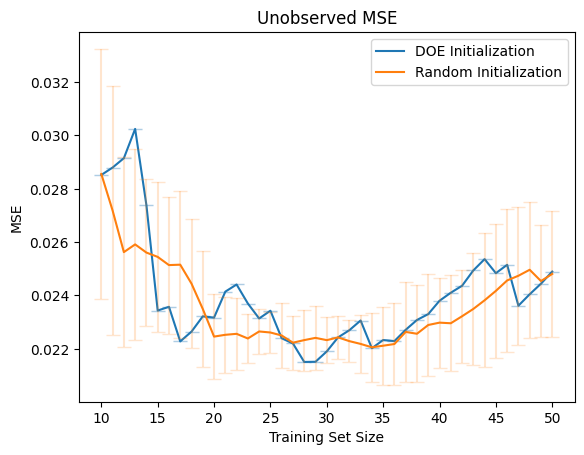

In [12]:
log_types = ['CV_MSE', 'MSE']
for log_type in log_types:
    filenames = [f'DOE_US_{log_type}.npy',f'RAND_US_{log_type}.npy']
    labels = 'DOE Initialization', 'Random Initialization'
    fig, ax = PlotData(filenames, labels)
    
    plot_title = ''
    if log_type[:2] == 'CV':
        plot_title = 'Cross Validation '
        log_type = log_type[3:]
    else:
        plot_title = 'Unobserved '
    plot_title = plot_title + log_type

    ax.set_title(plot_title)
    ax.set_ylabel(log_type)
    ax.set_xlabel('Training Set Size')
    plt.show(fig)
filepaths = ['DOE_US.npy', 'RAND_US.npy']

ax.set_title('Mean Squared Error')
ax.set_ylabel('MSE')
plt.show(fig)